In [2]:
# En esta celda se van a importar librerías necesarias para manejo y representación de datos,
# hacer cálculos, entrenar al modelo, etc.

# Se instala librería fetch_ucirepo para descargar datasets
!pip install ucimlrepo
# Se descargan librerías como: pandas para manejo de datos, matplotlib para generar gráficos,
# numpy para hacer cálculos numéricos, y TensorFlow para entrenar el modelo
from ucimlrepo import fetch_ucirepo
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
# Download `occupancy-detection` dataset
# using the id=357
occupancy_detection = fetch_ucirepo(id=357)

# Build the feature and the target data sets
data = occupancy_detection.data.original

In [4]:
# Elimina las columnas 'date' e 'id' porque son variables que no aportan al modelo
df = data.drop(['date', 'id'], axis=1)

# Convierte todas las columnas a valores numéricos y maneja valores inválidos
df[df.columns] = df[df.columns].apply(pd.to_numeric, errors='coerce')

# Elimina las filas con valores faltantes para no generar errores
df = df.dropna()

In [5]:
# Imprime dataframe para ver las primeras y últimas muestras
df

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,23.180,27.2720,426.00,721.25,0.004793,1.0
1,23.150,27.2675,429.50,714.00,0.004783,1.0
2,23.150,27.2450,426.00,713.50,0.004779,1.0
3,23.150,27.2000,426.00,708.25,0.004772,1.0
4,23.100,27.2000,426.00,704.50,0.004757,1.0
...,...,...,...,...,...,...
20557,20.815,27.7175,429.75,1505.25,0.004213,1.0
20558,20.865,27.7450,423.50,1514.50,0.004230,1.0
20559,20.890,27.7450,423.50,1521.50,0.004237,1.0
20560,20.890,28.0225,418.75,1632.00,0.004279,1.0


In [6]:
# Se muestran estadísticas de los datos para resumir el contenido
df.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000
mean,20.906212,27.655925,130.756622,690.553276,0.004228,0.231031
std,1.055315,4.982154,210.430875,311.201281,0.000768,0.421503
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,20.200000,24.500000,0.000000,460.000000,0.003719,0.000000
50%,20.700000,27.290000,0.000000,565.416667,0.004292,0.000000
75%,21.525000,31.290000,301.000000,804.666667,0.004832,0.000000
max,24.408333,39.500000,1697.250000,2076.500000,0.006476,1.000000


In [7]:
# Fija una semilla aleatoria para reproducibilidad
tf.random.set_seed(4500)

In [8]:
# Separa las características (X) de la variable objetivo
X = df.drop(["Occupancy"], axis=1)
# Separa las variable objetivo (y) de las características
y = df['Occupancy']

In [9]:
# Divide los datos en conjuntos de entrenamiento y prueba
# los parámetros a introducir son características, variable objetivo,
# proporción de la partición de pruebas, semilla para que la división sea la
# misma si ejecutamos de nuevo el código y si queremos mezclar los datos antes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [10]:
# Inicializa un escalador estándar para normalizar las características
scaler = StandardScaler()
# Aplica la normalización a los datos de entrenamiento
X_train = scaler.fit_transform(X_train)
# Aplica la misma normalización a los datos de prueba
X_test = scaler.transform(X_test)

In [11]:
# Importa la función expit para cálculos logísticos
from scipy.special import expit

# Define la clase del modelo de neurona
class NeuronModel():

    # Inicializa la clase con los datos de entrada, tasa de aprendizaje y umbral de error
    def __init__(self, X, y, learning_rate=0.01, error_threshold=0.001) -> None:

        # Asegura que los datos X no estén vacíos
        assert X.size != 0, "X cannot be empty"
        # Asegura que los datos y no estén vacíos
        assert y.size != 0, "y cannot be empty"
        # Asegura que la tasa de aprendizaje sea positivo
        assert learning_rate > 0, "learning rate must be positive"

        # Convierte X a un array de numpy si no lo es, así está optimizada
        if not isinstance(X, np.ndarray):
            X = X.to_numpy()

        # Convierte y a un array de numpy si no lo es, así está optimizada
        if not isinstance(y, np.ndarray):
            y = y.to_numpy().reshape(-1,1)

        # Guardamos nuestras variables de clase
        self.X = X
        self.y = y
        self.learning_rate = learning_rate

        # Inicializa los pesos w en ceros dependiendo del número de columnas
        # de la variable de características X
        self.w = np.zeros((X.shape[1], 1))
        # Inicializa el sesgo b con ceros
        self.b = np.zeros((1, 1))
        # Inicializar número de muestras
        self.N = X.shape[0]
        # Lista para almacenar los valores de la función de costo en cada iteración
        self.J_iter = list()
        # Umbral para detener el entrenamiento cuando el error es suficientemente pequeño
        self.stopping_tolerance = error_threshold

    # Calcula la función logística sigmoide
    def compute_logistic(self, w, b, X):
        return expit(X@w + b)

    # Calcula la función de costo (entropía cruzada)
    def compute_cost(self, y_hat, y, N):
        L = y*np.log(y_hat) + (1-y)*np.log(1-y_hat)
        J = -L.sum() / N
        return J

    # Realiza la propagación hacia adelante para obtener las predicciones
    def forward_propagation(self, w, b, X):
        # Calcula la función logística
        a = self.compute_logistic(w, b, X)
        return a

    # Calcula los gradientes para la retropropagación (derivadas parciales)
    def backward_propagation(self, y_hat, y, w, X):
        # Guarda tamaño de muestras
        N = X.shape[0]
        # Se calcula gradientes con las expresiones usando predicciones (y^),
        # variable objetivo (y), características (X) y el número demuestras (N)
        gradient_w = np.multiply(y_hat - y, X).sum(axis=0) / N
        gradient_w = gradient_w.reshape(w.shape)
        gradient_b = (y_hat - y).sum() / N
        gradient_b = gradient_b.reshape(-1,1)
        # Regresamos ambos gradientes
        return gradient_w, gradient_b

    # Actualiza los parámetros (pesos y sesgo) con los gradientes
    def update_parameters(self, param, gradient):
        return np.subtract(param, np.multiply(self.learning_rate, gradient))

    # Entrena el modelo ajustando los pesos y el sesgo
    def train(self, verbose=0):
        # Realiza la propagación hacia adelante para calcular la predicción inicial
        y_hat = self.forward_propagation(self.w, self.b, self.X)
        # Calcula de la función de costo incial
        J_prev = self.compute_cost(y_hat, self.y, self.N)
        # Inicializa función costo global en 0 y error porcentual en 100
        J, current_percentage_error = 0, 100
        # Recupero los pesos inicializados y el sesgo
        w, b = self.w, self.b

        # Aquí se implementa el gradiente descendiente
        # Itera hasta que el error porcentual sea menor que el umbral
        while current_percentage_error > self.stopping_tolerance:
            # Costo anterior es el J actual
            J_prev = J
            # Realiza la propagación hacia adelante
            y_hat = self.forward_propagation(w, b, self.X)
            # Calcula los gradientes con propagación ahora hacia atrás
            gradient_w, gradient_b = self.backward_propagation(y_hat, self.y, w, self.X)
            # Actualiza los pesos y el sesgo
            w = self.update_parameters(w, gradient_w)
            b = self.update_parameters(b, gradient_b)
            # Calcula el nuevo costo después de actualizar los parámetros
            y_hat = self.forward_propagation(w, b, self.X)
            J = self.compute_cost(y_hat, self.y, self.N)
            self.J_iter.append(J)
            # Calcula el error porcentual para verificar si se debe detener el entrenamiento
            current_percentage_error = np.abs((J - J_prev)/J)*100
            # Imprime el costo actual si está en modo verbose
            if verbose:
                print(f"J_previous: {J_prev:8.6f} \t"
                      f"J_current: {J:8.6f} \t"
                      f"Error: {current_percentage_error:8.6f}")
        # Almacena los parámetros finales
        self.w = w
        self.b = b

    # Realiza predicciones en los datos proporcionados
    def predict(self, X):
        a = self.forward_propagation(self.w, self.b, X)
        return a

    # Grafica el valor de la función de costo a lo largo de las iteraciones
    def plot_cost_function(self):
        plt.plot(self.J_iter)
        plt.xlabel('Iteration')
        plt.ylabel(r"$J_{\mathbf{w}}$")

    # Evalúa el modelo comparando las predicciones con los valores reales
    def evaluate(self, y_hat, y):
        # Convierte y a un array de numpy si no lo es
        if not isinstance(y, np.ndarray):
            y = y.to_numpy().reshape(-1,1)
        # Binariza las predicciones en 0 o 1
        y_hat[y_hat >= 0.5] = 1
        y_hat[y_hat < 0.5] = 0
        # Calcula el error como la proporción de predicciones incorrectas
        err = np.where((np.abs(y - y_hat) > 0) == True)[0]
        # Devuelve la precisión como 1 - tasa de error
        return 1 - err.shape[0] / y.shape[0]

    # Devuelve los parámetros (pesos y sesgo)
    def get_parameters(self):
        return np.vstack((self.w, self.b))


In [12]:
# Inicializa nuestra neurona con los parámetros de datos de entrenamiento,
# datos de prueba, tasa de aprendizaje y error porcentual mínimo entre costos
# para parar el entrenamiento
model = NeuronModel(X=X_train, y=y_train, learning_rate=0.001, error_threshold=0.01)
# Entrena el modelo, la salida son valores numéricos
model.train(verbose=1)

Se han truncado las últimas 5000 líneas del flujo de salida.
J_previous: 0.653898 	J_current: 0.653599 	Error: 0.045632
J_previous: 0.653599 	J_current: 0.653301 	Error: 0.045610
J_previous: 0.653301 	J_current: 0.653004 	Error: 0.045588
J_previous: 0.653004 	J_current: 0.652706 	Error: 0.045566
J_previous: 0.652706 	J_current: 0.652409 	Error: 0.045544
J_previous: 0.652409 	J_current: 0.652112 	Error: 0.045522
J_previous: 0.652112 	J_current: 0.651816 	Error: 0.045500
J_previous: 0.651816 	J_current: 0.651519 	Error: 0.045478
J_previous: 0.651519 	J_current: 0.651223 	Error: 0.045457
J_previous: 0.651223 	J_current: 0.650928 	Error: 0.045435
J_previous: 0.650928 	J_current: 0.650632 	Error: 0.045413
J_previous: 0.650632 	J_current: 0.650337 	Error: 0.045391
J_previous: 0.650337 	J_current: 0.650042 	Error: 0.045369
J_previous: 0.650042 	J_current: 0.649747 	Error: 0.045348
J_previous: 0.649747 	J_current: 0.649453 	Error: 0.045326
J_previous: 0.649453 	J_current: 0.649159 	Error: 0.04

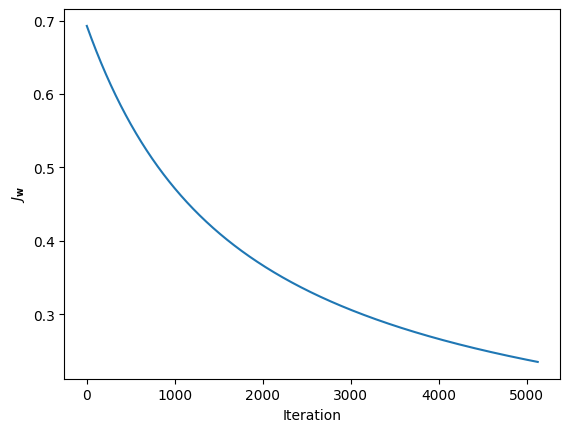

In [13]:
# Grafica la función de costo para ver su comportamiento a
# medida que aumentan el número de iteraciones, la salida es una gráfica de línea
# que muestra como se reduce el costo con cada iteración hasta llegar al deseado
model.plot_cost_function()

In [14]:
# Realiza predicciones sobre los datos de prueba
y_predictions = model.predict(X=X_test)

In [15]:
# Obtiene los parámetros de peso y sesgo terminando el entrenamiento,
# la salida son valores numéricos que permiten comparar los pesos calculados
model.get_parameters()

array([[ 0.3649771 ],
       [-0.00579411],
       [ 0.99736606],
       [ 0.36436746],
       [ 0.14157246],
       [-0.8332579 ]])

In [16]:
# Evalúa el rendimiento del modelo en los datos de prueba, la salida es
# la proporción de predicciones correctas hechas por el modelo
model.evaluate(y_hat=y_predictions, y=y_test)

0.9533073929961089

In [17]:
# A continuación se van a calcular distintas métricas de desempeño del modelo
# Importa las funciones a usar para obtener estas métricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Obtener las predicciones binarizadas (0 o 1)
y_predictions_binary = model.predict(X=X_test)
y_predictions_binary[y_predictions_binary >= 0.5] = 1
y_predictions_binary[y_predictions_binary < 0.5] = 0

# Calcula las métricas de accuracy, precision, recall y f1 score
accuracy = accuracy_score(y_test, y_predictions_binary)
precision = precision_score(y_test, y_predictions_binary)
recall = recall_score(y_test, y_predictions_binary)
f1 = f1_score(y_test, y_predictions_binary)

# Calcula la matriz de confusión para extraer la Specificity
tn, fp, fn, tp = confusion_matrix(y_test, y_predictions_binary).ravel()
specificity = tn / (tn + fp)

# Imprime las métricas calculadas para evaluar el desemeño del modelo,
# la salida son valores numéricos
# Proporción de predicciones correctas
print(f'Accuracy: {accuracy:.4f}')
# Proporción de verdaderos positivos en los clasificados como positivos
print(f'Precision: {precision:.4f}')
# Proporción de verdaderos positivos entre todos los elementos realmente positivos
print(f'Recall: {recall:.4f}')
# Proporción de verdaderos negativos entre todos los elementos realmente negativos
print(f'Specificity: {specificity:.4f}')
# Media armónica de la precisión y el recall
print(f'F1 Score: {f1:.4f}')

# Las métricas son buenas pero es notable por la gráfica del costo que subiendo
# el learning rate se obtienen mejores resultados pero se usa el 0.001 porque
# es el predefinido para el optimizador adam y así comparamos justamente
# ambos métodos de entrenamiento.

# Sección C
# Analizando las métricas obtenidas se llegó a la conclusión de que el mejor
# modelo fue usando tensorflow ya que para esta aplicación es más importante
# la métrcia de accuracy y el modelo A obtuvo 0.9533 y el B 0.9895, esto usando
# el mismo learning rate y data sets.


Accuracy: 0.9533
Precision: 0.8373
Recall: 0.9849
Specificity: 0.9441
F1 Score: 0.9051
